In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
from pyspark.sql import SparkSession, functions, types
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, mean, stddev,stddev_pop,avg,max,to_timestamp,udf,desc
from pyspark.sql import Window

In [2]:
spark = SparkSession.builder.appName('weather prediction').getOrCreate()
spark.sparkContext.setLogLevel('WARN')
assert spark.version >= '2.4'  # make sure we have Spark 2.4+

In [3]:
input = 'EDS_13.csv'
# Defining the schema for tmax datasets
def sensor_schema():
    sen_schema = types.StructType([
        types.StructField('timestamp', types.StringType()),
        types.StructField('X', types.DoubleType()),
        types.StructField('Y', types.DoubleType()),
        types.StructField('Z', types.DoubleType()),
    ])
    return sen_schema

sens_schema = sensor_schema()
#Spark read of data
temp = spark.read.csv(input, schema=sens_schema)

In [4]:
temp.createOrReplaceTempView("temp")
temp = spark.sql("select timestamp,(Y*-1) as Y from temp where timestamp between '2018-07-09 12:00:00' and '2018-08-09 12:00:00'")
temp.show()

+--------------------+--------+
|           timestamp|       Y|
+--------------------+--------+
|2018-07-09 12:00:...|0.128906|
|2018-07-09 12:00:...|0.121094|
|2018-07-09 12:00:...|0.105469|
|2018-07-09 12:00:...|0.113281|
|2018-07-09 12:00:...|0.117188|
|2018-07-09 12:00:...|0.121094|
|2018-07-09 12:00:...|0.113281|
|2018-07-09 12:00:...|0.121094|
|2018-07-09 12:00:...|0.121094|
|2018-07-09 12:00:...|0.113281|
|2018-07-09 12:00:...|0.121094|
|2018-07-09 12:00:...|   0.125|
|2018-07-09 12:00:...|   0.125|
|2018-07-09 12:00:...|0.128906|
|2018-07-09 12:00:...|   0.125|
|2018-07-09 12:00:...|0.121094|
|2018-07-09 12:00:...|   0.125|
|2018-07-09 12:00:...|0.128906|
|2018-07-09 12:00:...|0.117188|
|2018-07-09 12:00:...|   0.125|
+--------------------+--------+
only showing top 20 rows



In [5]:
# UDF for converting column type from vector to double type
unlist = udf(lambda x: round(float(list(x)[0]),6), types.DoubleType())

assembler = VectorAssembler(
    inputCols=["Y"],
    outputCol="Yvector")
tempdata = assembler.transform(temp)
scaler = StandardScaler(inputCol="Yvector", outputCol="Yscale",withMean=True, withStd=True)
scalerModel = scaler.fit(tempdata)
scaledData = scalerModel.transform(tempdata).withColumn("Yscale", unlist("Yscale")).drop("Yvector").cache()
scaledData.show()

+--------------------+--------+---------+
|           timestamp|       Y|   Yscale|
+--------------------+--------+---------+
|2018-07-09 12:00:...|0.128906| 3.182295|
|2018-07-09 12:00:...|0.121094| 0.785833|
|2018-07-09 12:00:...|0.105469|-4.007396|
|2018-07-09 12:00:...|0.113281|-1.610935|
|2018-07-09 12:00:...|0.117188|-0.412397|
|2018-07-09 12:00:...|0.121094| 0.785833|
|2018-07-09 12:00:...|0.113281|-1.610935|
|2018-07-09 12:00:...|0.121094| 0.785833|
|2018-07-09 12:00:...|0.121094| 0.785833|
|2018-07-09 12:00:...|0.113281|-1.610935|
|2018-07-09 12:00:...|0.121094| 0.785833|
|2018-07-09 12:00:...|   0.125| 1.984064|
|2018-07-09 12:00:...|   0.125| 1.984064|
|2018-07-09 12:00:...|0.128906| 3.182295|
|2018-07-09 12:00:...|   0.125| 1.984064|
|2018-07-09 12:00:...|0.121094| 0.785833|
|2018-07-09 12:00:...|   0.125| 1.984064|
|2018-07-09 12:00:...|0.128906| 3.182295|
|2018-07-09 12:00:...|0.117188|-0.412397|
|2018-07-09 12:00:...|   0.125| 1.984064|
+--------------------+--------+---

In [12]:
scaledData.sort(desc("Yscale")).show()

+--------------------+---------+---------+
|           timestamp|        Y|   Yscale|
+--------------------+---------+---------+
|2018-07-18 09:26:...|-0.046875|21.982082|
|2018-07-27 14:39:...|-0.050781|20.783852|
|2018-07-12 16:04:...|-0.050781|20.783852|
|2018-08-03 11:50:...|-0.050781|20.783852|
|2018-07-27 12:13:...|-0.054688|19.585314|
|2018-07-09 17:10:...|-0.058594|18.387084|
|2018-07-31 21:52:...|  -0.0625|17.188853|
|2018-07-20 09:10:...|  -0.0625|17.188853|
|2018-07-13 20:43:...|  -0.0625|17.188853|
|2018-07-28 11:48:...|  -0.0625|17.188853|
|2018-07-18 10:15:...|  -0.0625|17.188853|
|2018-07-19 11:23:...|-0.066406|15.990622|
|2018-08-06 10:14:...|-0.066406|15.990622|
|2018-07-12 16:04:...|-0.066406|15.990622|
|2018-07-26 09:22:...|-0.066406|15.990622|
|2018-07-27 08:31:...|-0.070313|14.792085|
|2018-07-28 11:48:...|-0.070313|14.792085|
|2018-07-31 16:27:...|-0.070313|14.792085|
|2018-07-11 08:38:...|-0.070313|14.792085|
|2018-07-17 02:30:...|-0.070313|14.792085|
+----------

In [13]:
scaledData.sort("Yscale").show()

+--------------------+---------+----------+
|           timestamp|        Y|    Yscale|
+--------------------+---------+----------+
|2018-07-13 16:00:...|-0.261719|-43.924897|
|2018-07-16 07:36:...|-0.238281|-36.734899|
|2018-07-31 10:23:...|-0.207031|-27.148441|
|2018-08-08 14:36:...|-0.195313|-23.553749|
|2018-07-18 10:15:...|  -0.1875|-21.156981|
|2018-08-01 12:27:...|-0.183594| -19.95875|
|2018-07-19 14:56:...|-0.183594| -19.95875|
|2018-07-23 14:37:...|-0.183594| -19.95875|
|2018-07-27 15:08:...|-0.183594| -19.95875|
|2018-07-29 19:27:...|-0.175781|-17.561982|
|2018-07-24 21:50:...|-0.175781|-17.561982|
|2018-07-17 07:45:...|-0.175781|-17.561982|
|2018-07-25 12:16:...|-0.175781|-17.561982|
|2018-07-20 07:18:...|-0.175781|-17.561982|
|2018-07-11 12:38:...|-0.175781|-17.561982|
|2018-07-12 20:56:...|-0.171875|-16.363752|
|2018-07-18 10:15:...|-0.171875|-16.363752|
|2018-07-28 11:48:...|-0.171875|-16.363752|
|2018-07-27 15:51:...|-0.171875|-16.363752|
|2018-07-25 19:36:...|-0.171875|

In [6]:
scaledData.createOrReplaceTempView("scaledData")
temp_df = spark.sql("select SUBSTRING_INDEX(timestamp, '.', 1) as timestamp,Yscale from scaledData where timestamp between '2018-07-18 10:15:00' and '2018-07-18 10:16:00' ").cache()

In [7]:
temp_df1 = spark.sql("select SUBSTRING_INDEX(timestamp, '.', 1) as timestamp,Y,Yscale,ROUND(Yscale, 0) as Y_norm from scaledData").cache()
temp_df1.show()
temp_df1.createOrReplaceTempView("temp_df1")
temp_lift13 = spark.sql("select Y_norm as Yround, count(Y_norm) as Ycount from temp_df1 GROUP BY Yround Order BY Ycount  DESC")
temp_lift13.select("*").toPandas().to_csv("Lift13_dist.csv")
temp_lift13.show()

+-------------------+--------+---------+------+
|          timestamp|       Y|   Yscale|Y_norm|
+-------------------+--------+---------+------+
|2018-07-09 12:00:00|0.128906| 3.182295|   3.0|
|2018-07-09 12:00:00|0.121094| 0.785833|   1.0|
|2018-07-09 12:00:00|0.105469|-4.007396|  -4.0|
|2018-07-09 12:00:00|0.113281|-1.610935|  -2.0|
|2018-07-09 12:00:00|0.117188|-0.412397|   0.0|
|2018-07-09 12:00:00|0.121094| 0.785833|   1.0|
|2018-07-09 12:00:00|0.113281|-1.610935|  -2.0|
|2018-07-09 12:00:00|0.121094| 0.785833|   1.0|
|2018-07-09 12:00:00|0.121094| 0.785833|   1.0|
|2018-07-09 12:00:00|0.113281|-1.610935|  -2.0|
|2018-07-09 12:00:00|0.121094| 0.785833|   1.0|
|2018-07-09 12:00:00|   0.125| 1.984064|   2.0|
|2018-07-09 12:00:00|   0.125| 1.984064|   2.0|
|2018-07-09 12:00:00|0.128906| 3.182295|   3.0|
|2018-07-09 12:00:00|   0.125| 1.984064|   2.0|
|2018-07-09 12:00:00|0.121094| 0.785833|   1.0|
|2018-07-09 12:00:00|   0.125| 1.984064|   2.0|
|2018-07-09 12:00:00|0.128906| 3.182295|

In [8]:
temp_df = temp_df.withColumn("timestamp1", to_timestamp("timestamp", 'yyyy-MM-dd HH:mm:ss')).cache()
temp_df.show()

+-------------------+---------+-------------------+
|          timestamp|   Yscale|         timestamp1|
+-------------------+---------+-------------------+
|2018-07-18 10:15:00| 0.785833|2018-07-18 10:15:00|
|2018-07-18 10:15:00| 0.785833|2018-07-18 10:15:00|
|2018-07-18 10:15:00| 0.785833|2018-07-18 10:15:00|
|2018-07-18 10:15:00| 0.785833|2018-07-18 10:15:00|
|2018-07-18 10:15:00| 1.984064|2018-07-18 10:15:00|
|2018-07-18 10:15:00| 1.984064|2018-07-18 10:15:00|
|2018-07-18 10:15:00| 1.984064|2018-07-18 10:15:00|
|2018-07-18 10:15:00|-1.610935|2018-07-18 10:15:00|
|2018-07-18 10:15:00|-0.412397|2018-07-18 10:15:00|
|2018-07-18 10:15:00|-0.412397|2018-07-18 10:15:00|
|2018-07-18 10:15:00| 1.984064|2018-07-18 10:15:00|
|2018-07-18 10:15:00| 0.785833|2018-07-18 10:15:00|
|2018-07-18 10:15:00|-0.412397|2018-07-18 10:15:00|
|2018-07-18 10:15:00| 1.984064|2018-07-18 10:15:00|
|2018-07-18 10:15:00|-0.412397|2018-07-18 10:15:00|
|2018-07-18 10:15:00|-0.412397|2018-07-18 10:15:00|
|2018-07-18 

In [9]:
movAvg = temp_df.withColumn("movingAverage", avg(temp_df["Yscale"])
             .over( Window.partitionBy(temp_df["timestamp1"]).rowsBetween(-1,1))).cache()
movAvg.show()

+-------------------+---------+-------------------+--------------------+
|          timestamp|   Yscale|         timestamp1|       movingAverage|
+-------------------+---------+-------------------+--------------------+
|2018-07-18 10:15:13| 1.984064|2018-07-18 10:15:13|  1.3849485000000001|
|2018-07-18 10:15:13| 0.785833|2018-07-18 10:15:13|  0.7858333333333335|
|2018-07-18 10:15:13|-0.412397|2018-07-18 10:15:13|            0.386423|
|2018-07-18 10:15:13| 0.785833|2018-07-18 10:15:13|  0.7858333333333333|
|2018-07-18 10:15:13| 1.984064|2018-07-18 10:15:13|  0.7858333333333335|
|2018-07-18 10:15:13|-0.412397|2018-07-18 10:15:13|-0.41249933333333333|
|2018-07-18 10:15:13|-2.809165|2018-07-18 10:15:13|-0.41249933333333333|
|2018-07-18 10:15:13| 1.984064|2018-07-18 10:15:13| -0.8120120000000001|
|2018-07-18 10:15:13|-1.610935|2018-07-18 10:15:13| -0.8120120000000001|
|2018-07-18 10:15:13|-2.809165|2018-07-18 10:15:13| -0.8120119999999998|
|2018-07-18 10:15:13| 1.984064|2018-07-18 10:15:13|

In [10]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [11]:
%time temp_pandas = temp_df.select("*").toPandas()
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 65.9 ms, sys: 61.8 ms, total: 128 ms
Wall time: 768 ms
CPU times: user 20.1 ms, sys: 7.88 ms, total: 28 ms
Wall time: 417 ms


### Plots of Anomalies detected for Lift 15. 10 different anomalies are plotted here

### Anomaly1

(array([  0., 100., 200., 300., 400., 500., 600., 700., 800.]),
 <a list of 9 Text xticklabel objects>)

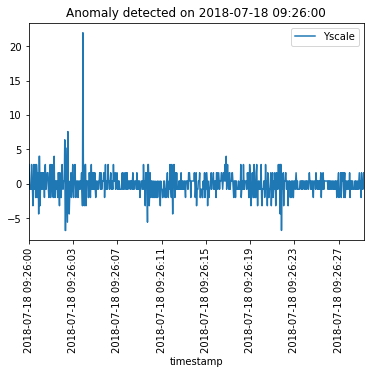

In [146]:
temp_pandas.plot(x ='timestamp', y='Yscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-18 09:26:00")
plt.xticks(rotation=90)

(array([736893.39305556, 736893.39311343, 736893.3931713 , 736893.39322917,
        736893.39328704, 736893.39334491]),
 <a list of 6 Text xticklabel objects>)

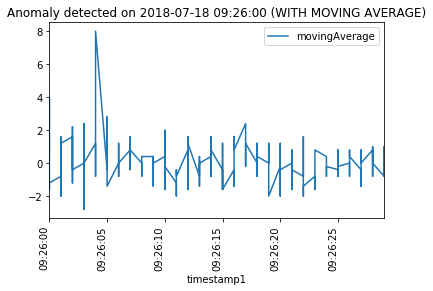

In [147]:
# This is the plot for window size 3

temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-18 09:26:00 (WITH MOVING AVERAGE)")
plt.xticks(rotation=90)

### Anomaly2

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

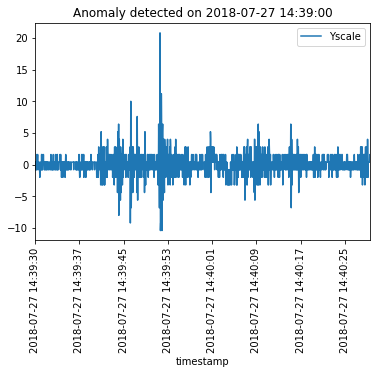

In [125]:
temp_pandas.plot(x ='timestamp', y='Yscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-27 14:39:00")
plt.xticks(rotation=90)

(array([736902.61076389, 736902.61087963, 736902.61099537, 736902.61111111,
        736902.61122685, 736902.61134259]),
 <a list of 6 Text xticklabel objects>)

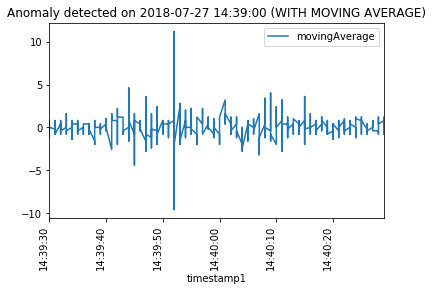

In [126]:

# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-27 14:39:00 (WITH MOVING AVERAGE)")
plt.xticks(rotation=90)

### Anomaly3

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

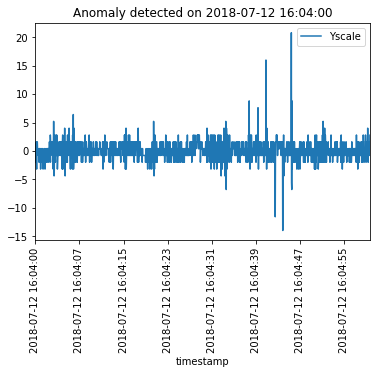

In [154]:
temp_pandas.plot(x ='timestamp', y='Yscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-12 16:04:00")
plt.xticks(rotation=90)

(array([736887.66944444, 736887.66956019, 736887.66967593, 736887.66979167,
        736887.66990741, 736887.67002315]),
 <a list of 6 Text xticklabel objects>)

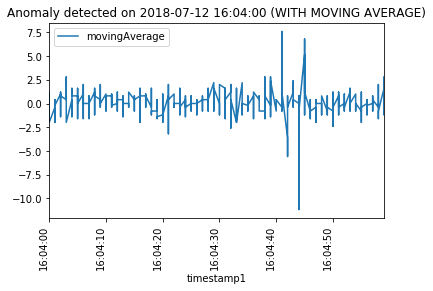

In [156]:

# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-12 16:04:00 (WITH MOVING AVERAGE)")
plt.xticks(rotation=90)

### Anomaly4

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

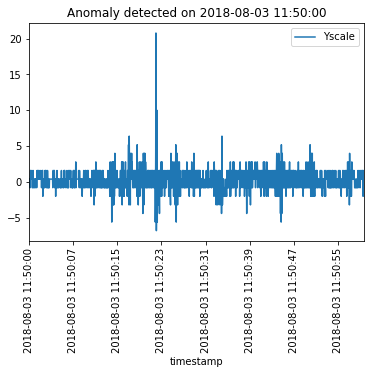

In [162]:
temp_pandas.plot(x ='timestamp', y='Yscale', kind = 'line')
plt.title("Anomaly detected on 2018-08-03 11:50:00")
plt.xticks(rotation=90)

(array([736909.49305556, 736909.4931713 , 736909.49328704, 736909.49340278,
        736909.49351852, 736909.49363426]),
 <a list of 6 Text xticklabel objects>)

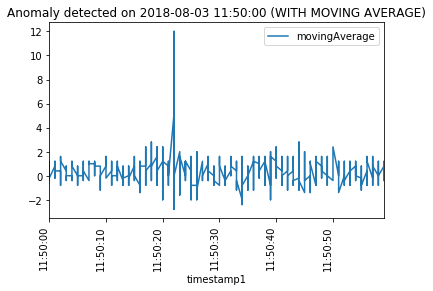

In [163]:

# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-08-03 11:50:00 (WITH MOVING AVERAGE)")
plt.xticks(rotation=90)

### Anomaly5

(array([  0.,  50., 100., 150., 200., 250., 300.]),
 <a list of 7 Text xticklabel objects>)

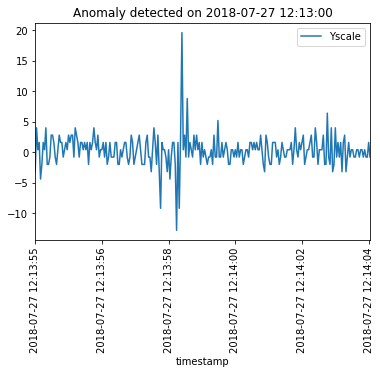

In [182]:
temp_pandas.plot(x ='timestamp', y='Yscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-27 12:13:00")
plt.xticks(rotation=90)

(array([736902.50966435, 736902.50967593, 736902.5096875 , 736902.50969907,
        736902.50971065, 736902.50972222, 736902.5097338 , 736902.50974537,
        736902.50975694, 736902.50976852]),
 <a list of 10 Text xticklabel objects>)

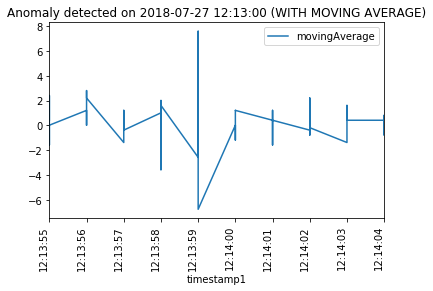

In [184]:

# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-27 12:13:00 (WITH MOVING AVERAGE)")
plt.xticks(rotation=90)

### Anomaly6

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.,
        1800.]), <a list of 10 Text xticklabel objects>)

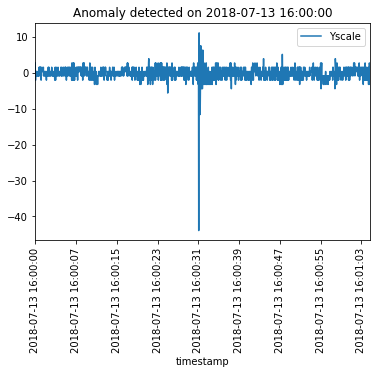

In [190]:
temp_pandas.plot(x ='timestamp', y='Yscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-13 16:00:00")
plt.xticks(rotation=90)

(array([736888.66666667, 736888.66678241, 736888.66689815, 736888.66701389,
        736888.66712963, 736888.66724537, 736888.66736111]),
 <a list of 7 Text xticklabel objects>)

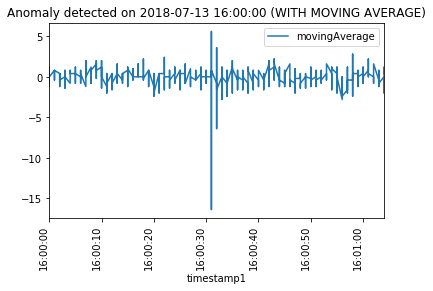

In [192]:

# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-13 16:00:00 (WITH MOVING AVERAGE)")
plt.xticks(rotation=90)

### Anomaly7

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

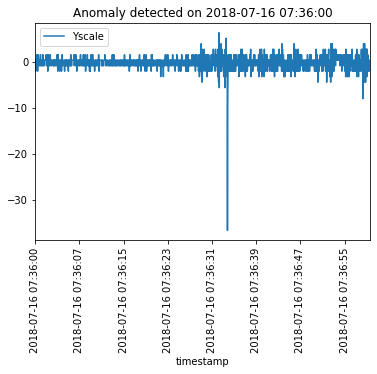

In [198]:
temp_pandas.plot(x ='timestamp', y='Yscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-16 07:36:00")
plt.xticks(rotation=90)

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

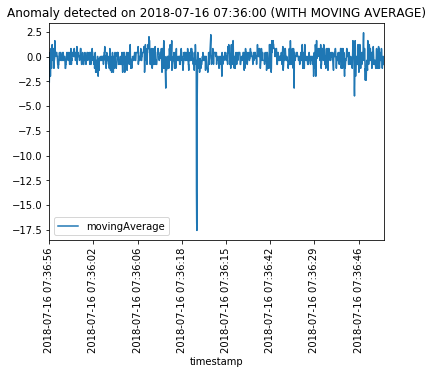

In [199]:

temp_avg.plot(x ='timestamp', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-16 07:36:00 (WITH MOVING AVERAGE)")
plt.xticks(rotation=90)

### Anomaly8

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

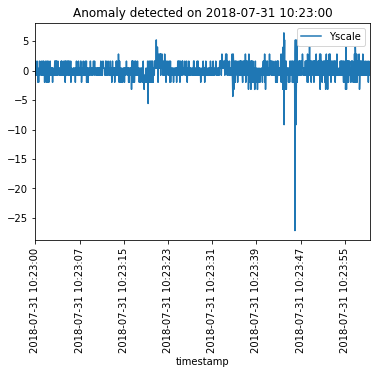

In [206]:
temp_pandas.plot(x ='timestamp', y='Yscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-31 10:23:00")
plt.xticks(rotation=90)

(array([736906.43263889, 736906.43275463, 736906.43287037, 736906.43298611,
        736906.43310185, 736906.43321759]),
 <a list of 6 Text xticklabel objects>)

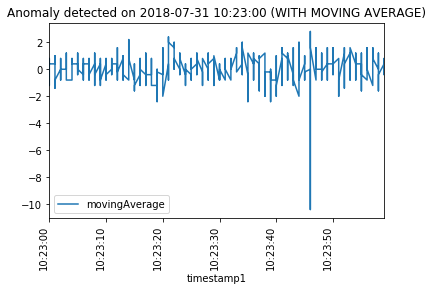

In [207]:

# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-31 10:23:00 (WITH MOVING AVERAGE)")
plt.xticks(rotation=90)

### Anomaly9

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

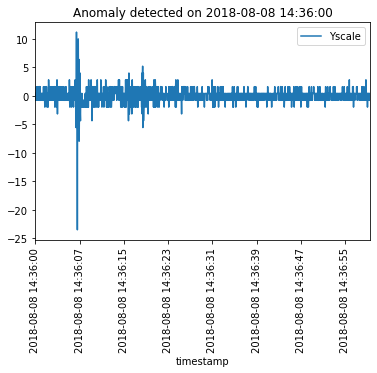

In [213]:
temp_pandas.plot(x ='timestamp', y='Yscale', kind = 'line')
plt.title("Anomaly detected on 2018-08-08 14:36:00")
plt.xticks(rotation=90)

(array([736914.60833333, 736914.60844907, 736914.60856481, 736914.60868056,
        736914.6087963 , 736914.60891204]),
 <a list of 6 Text xticklabel objects>)

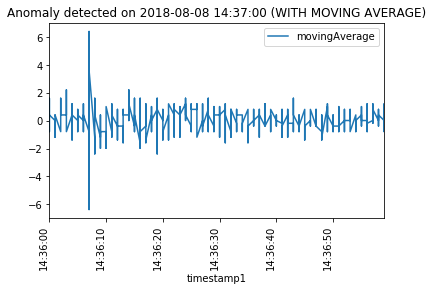

In [214]:

# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-08-08 14:37:00 (WITH MOVING AVERAGE)")
plt.xticks(rotation=90)

### Anomaly10

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

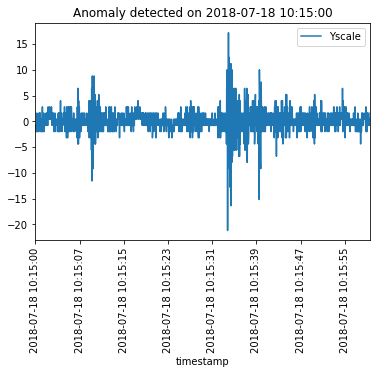

In [222]:
temp_pandas.plot(x ='timestamp', y='Yscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-18 10:15:00")
plt.xticks(rotation=90)

(array([736893.42708333, 736893.42719907, 736893.42731481, 736893.42743056,
        736893.4275463 , 736893.42766204]),
 <a list of 6 Text xticklabel objects>)

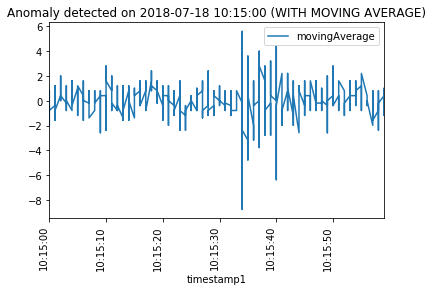

In [223]:

# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-18 10:15:00 (WITH MOVING AVERAGE)")
plt.xticks(rotation=90)

## Normal Cases

In [16]:
normaldata = spark.sql("select * from temp_df1 where Y_norm = 1.0 ")

normaldata.createOrReplaceTempView("normaldata")
normaldata.show()

temp_norm = spark.sql("select SUBSTRING_INDEX(timestamp, '.', 1) as timestamp,Yscale from scaledData where timestamp between '2018-07-09 12:00:00' and '2018-07-09 12:01:00' ").cache()

temp_norm = temp_norm.withColumn("timestamp1", to_timestamp("timestamp", 'yyyy-MM-dd HH:mm:ss')).cache()
temp_norm.show()


movAvg_norm = temp_norm.withColumn("movingAverage", avg(temp_norm["Yscale"])
             .over( Window.partitionBy(temp_norm["timestamp1"]).rowsBetween(-3,3))).cache()
movAvg_norm.show()

spark.conf.set("spark.sql.execution.arrow.enabled", "true")

%time temp_pandas = temp_norm.select("*").toPandas()
%time temp_avg = movAvg_norm.select("*").toPandas()

+-------------------+--------+--------+------+
|          timestamp|       Y|  Yscale|Y_norm|
+-------------------+--------+--------+------+
|2018-07-09 12:00:00|0.121094|0.785833|   1.0|
|2018-07-09 12:00:00|0.121094|0.785833|   1.0|
|2018-07-09 12:00:00|0.121094|0.785833|   1.0|
|2018-07-09 12:00:00|0.121094|0.785833|   1.0|
|2018-07-09 12:00:00|0.121094|0.785833|   1.0|
|2018-07-09 12:00:00|0.121094|0.785833|   1.0|
|2018-07-09 12:00:00|0.121094|0.785833|   1.0|
|2018-07-09 12:00:00|0.121094|0.785833|   1.0|
|2018-07-09 12:00:00|0.121094|0.785833|   1.0|
|2018-07-09 12:00:01|0.121094|0.785833|   1.0|
|2018-07-09 12:00:01|0.121094|0.785833|   1.0|
|2018-07-09 12:00:01|0.121094|0.785833|   1.0|
|2018-07-09 12:00:01|0.121094|0.785833|   1.0|
|2018-07-09 12:00:01|0.121094|0.785833|   1.0|
|2018-07-09 12:00:01|0.121094|0.785833|   1.0|
|2018-07-09 12:00:01|0.121094|0.785833|   1.0|
|2018-07-09 12:00:01|0.121094|0.785833|   1.0|
|2018-07-09 12:00:01|0.121094|0.785833|   1.0|
|2018-07-09 1

### Normal Case 1

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

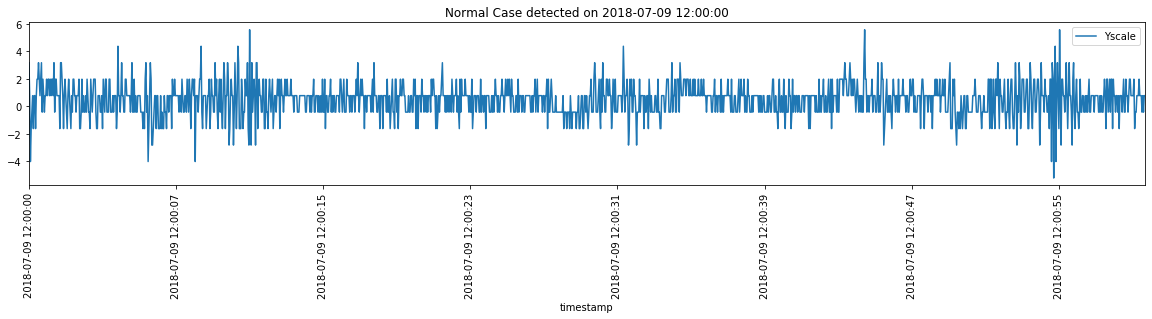

In [17]:
temp_pandas.plot(x ='timestamp', y='Yscale', kind = 'line')
plt.rcParams["figure.figsize"] = (20,3)
plt.title("Normal Case detected on 2018-07-09 12:00:00")

plt.xticks(rotation=90)